# Model Training and Evaluation

This notebook trains and evaluates machine learning models for gender and age classification using the extracted audio features.

# Import Required Libraries

This cell imports the libraries used the data processing, feature scaling, model training, evaluation, and model persistence.

In [6]:
# Import libraries for data manipulation and machine learning
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns


# Scikit-learn for preprocessing and evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, recall_score

# TensorFlow and Keras for building and training neural network models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Joblib for saving and loading models
from joblib import dump, load


# Load Feature Dataset

This cell loads the extracted audio feature dataset from disk and displays the first few rows to verify successful loading.

In [7]:
# Load dataset from a CSV file
features_path = r"D:/mcv-scripted-en-v23.0/cv-corpus-23.0-2025-09-05/features.csv"
df = pd.read_csv(features_path)

# Display the first few rows of the dataset
df.head()

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,age,gender,sentence_id
0,-214.32610,69.891610,-22.251526,42.737550,8.817623,-22.563150,-15.780383,-23.039673,-5.548550,4.620748,-23.012182,2.164026,-4.294652,fourties,female_feminine,d798beba6575771fb57cd1d5ff392c02f0a4991d3ccba7...
1,-351.05008,86.572960,22.794289,33.870155,23.073720,6.737885,2.148624,-1.785764,-8.746799,-1.878710,-1.364716,-13.292924,-4.634765,twenties,male_masculine,3c1f762645e5e4bcf32cb4ee6a898a8be81cd66da081c5...
2,-263.55438,38.373997,8.765067,10.966754,-21.524435,-25.976948,-15.802537,-15.827195,1.363906,-9.291619,-22.253017,2.304282,-18.349985,thirties,female_feminine,abd68fbf63d6f75b2b6b98057ea349b32dc23741d77920...
3,-361.89560,117.643070,12.162499,25.818653,-0.365172,0.214467,0.574238,-7.420811,-11.845445,-7.305350,1.308687,-2.366930,-6.036425,fourties,male_masculine,194c643d0a89cc50b68fc0149527f9c152d93ddc5a64ff...
4,-313.31790,91.715390,19.142248,48.952152,-12.414907,4.654750,-21.887197,1.974875,-8.159819,-15.324660,1.744357,-12.088483,3.569958,fourties,male_masculine,5645f6ac302629900ee53e78600dd77ccd5a5efb0e1d7c...


# Encode Gender Labels

This cell maps textual gender labels to numerical values, removes samples the unmapped labels, and displays the resulting class distribution.

In [8]:
# Encode Labels (gender)
gender_mapping = {
    "male": 0,
    "male_masculine": 0,
    "female": 1,
    "female_feminine": 1
}

# Map gender labels
df["gender_label"] = df["gender"].map(gender_mapping)
df = df.dropna(subset=["gender_label"])

# Print the distribution of gender labels
df["gender_label"].value_counts()

gender_label
0    731
1    269
Name: count, dtype: int64

# Prepare Input Features and Gender Labels

This cell separates MFCC features columns from the encoded gender labels to create input and target arrays for gender classification.

In [9]:
# Prepare features and labels (gender)
X = df.filter(regex="mfcc_").values
y = df["gender_label"].values

# Split Data into Training and Test Sets (Gender)

This cell splits the gender classification data into training and test sets using stratification to preserve class distribution.

In [10]:
# Train-test split with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale Features for Gender Classification

This cell standardises the input features using a training-set-fitted scaler to improve neural network training stability.

In [11]:
# Scaling the features using StandardScaler for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for later use in prediction
dump(scaler, "../models/feature_scaler.joblib")

['../models/feature_scaler.joblib']

# Define Gender Classification Model

This cell defines a multi-layer perception architecture for gender classification using fully connected layers and dropout.

In [12]:
# Create the model (gender)
model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(2, activation="softmax")
])

# Compile the model (gender)
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Print a summary of the model (gender)
model.summary()

c:\Users\Harley\Documents\GitHub\VoiceDemographicsNet\venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,042 (11.88 KB)

 Trainable params: 3,042 (11.88 KB)

 Non-trainable params: 0 (0.00 B)

# Train Gender Classification Model

This cell trains the neural network on the scaled training data with a validation split to monitor performance and prevent overfitting.

In [13]:
# Train the model (gender)
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32
)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5484 - loss: 0.7399 - val_accuracy: 0.6938 - val_loss: 0.6611
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7312 - loss: 0.5730 - val_accuracy: 0.7063 - val_loss: 0.5852
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7328 - loss: 0.5339 - val_accuracy: 0.7375 - val_loss: 0.5445
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7406 - loss: 0.5157 - val_accuracy: 0.7250 - val_loss: 0.5223
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7594 - loss: 0.4955 - val_accuracy: 0.7188 - val_loss: 0.5203
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7609 - loss: 0.4780 - val_accuracy: 0.7250 - val_loss: 0.5116
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7812 - loss: 0.4660 - val_accuracy: 0.7437 - val_loss: 0.5111
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7625 - loss: 0.4706 - val_accuracy: 0.7563 - v

# Evaluate Gender Classification Model

This cell evaluates the trained model on the test set and displays a classification report with precision, recall, and F1-score metrics for each gender class.

In [14]:
# Evaluate the model (gender)
y_pred_base = np.argmax(model.predict(X_test_scaled), axis=1)

# Print classification report (gender)
print(classification_report(y_test, y_pred_base))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       146
           1       0.70      0.48      0.57        54

    accuracy                           0.81       200
   macro avg       0.77      0.70      0.72       200
weighted avg       0.79      0.81      0.79       200



# Save Gender Classification Model

This cell saves the trained neural network model to disk in Keras format for future use and deployment.

In [15]:
# Save the model (gender)
model.save("../models/mlp_gender_classification_model.keras")

# Prepare Age Labels for Classification

This cell maps age categories to numeric labels for multi-class classification: teens(0), twnenties(1), thirties/fourties(2), and other ages(3), then remove any missing values.

In [16]:
# Prepare features and labels (age)
def map_age(age):
    if age in ["teens"]:
        return 0
    elif age in ["twenties"]:
        return 1
    elif age in ["thirties", "fourties"]:
        return 2
    else:
        return 3

# Map age labels
df["age_label"] = df["age"].apply(map_age)
df = df.dropna(subset=["age_label"])

# Split Age Classification Data

This cell extracts MFCC features and age labels, then splits the data into training(80%) and test(20%) sets with stratification to ensure balanced class distribution across both sets.

In [17]:
# Prepare features and labels (age)
X_age = df.filter(regex="mfcc_").values
y_age = df["age_label"].values

# Train-test split with stratification to maintain class distribution
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    X_age, y_age, test_size=0.2, random_state=42, stratify=y_age
)

# Scale Age Classification Features

This cell standardises the MFCC features using StandardScaler to normalise the data for improved model training then saves the scaler for consistent preprocessing during prediction.

In [18]:
# Scaling the features using StandardScaler for better model performance (age)
age_scaler = StandardScaler()
X_train_a = age_scaler.fit_transform(X_train_a)
X_test_a = age_scaler.transform(X_test_a)

# Save the scaler for later use in prediction 
dump(age_scaler, "../models/age_feature_scaler.joblib")

['../models/age_feature_scaler.joblib']

# Buiild, Train, and Evaluate Age Classification Model

This cell defines a multi-layer perception for 4-class age classification, trains it for 30 epochs and evalutes performance with a classification report. 

In [19]:
age_model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train_a.shape[1],)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(4, activation="softmax")
])

age_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

age_model.fit(X_train_a, y_train_a, epochs=30, batch_size=32)

y_pred_age = np.argmax(age_model.predict(X_test_a), axis=1)
print(classification_report(y_test_a, y_pred_age))

Epoch 1/30


c:\Users\Harley\Documents\GitHub\VoiceDemographicsNet\venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3338 - loss: 1.3721
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3975 - loss: 1.3003
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4162 - loss: 1.2711
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4288 - loss: 1.2455
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4550 - loss: 1.2342
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4400 - loss: 1.2216
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4500 - loss: 1.2156
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4600 - loss: 1.2028
Epoch 9/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4538 - loss: 1.1883
Epoch 10/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4762 - loss: 1.1815
Epoch 11/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4775 - loss: 1.1769
Epoch 12/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4850 - loss: 1.1633


# Gender Model with Class Weighting

This section retrains the gender classification model using class weights to reduce bias caused by class imbalance.

In [20]:
# Compute class weights to handle imbalanced classes
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

# Create a dictionary mapping class indices to weights
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

# Create the weighted model
weighted_model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(2, activation="softmax")
])

# Compile the weighted model
weighted_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train weighted model
history_weighted = weighted_model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    class_weight=class_weight_dict
)


Class weights: {0: np.float64(0.6837606837606838), 1: np.float64(1.8604651162790697)}
Epoch 1/30


c:\Users\Harley\Documents\GitHub\VoiceDemographicsNet\venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.4844 - loss: 0.7188 - val_accuracy: 0.7125 - val_loss: 0.6376
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6313 - loss: 0.6350 - val_accuracy: 0.7000 - val_loss: 0.5791
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7203 - loss: 0.5807 - val_accuracy: 0.7437 - val_loss: 0.5381
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7078 - loss: 0.5897 - val_accuracy: 0.7312 - val_loss: 0.5236
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7328 - loss: 0.5631 - val_accuracy: 0.7375 - val_loss: 0.5106
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7188 - loss: 0.5538 - val_accuracy: 0.7250 - val_loss: 0.5156
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7219 - loss: 0.5442 - val_accuracy: 0.7312 - val_loss: 0.5023
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7484 - loss: 0.5315 - val_accuracy: 0.7437 - val_loss: 0.

# Baseline vs Weighted Model Gender Model Evaluation

This section compares the performance of the baseline gender classification model against the class-weighted model using classification reports on the test dataset.

In [21]:
# Baseline model evaluation
y_pred_base = np.argmax(model.predict(X_test_scaled), axis=1)
print("Baseline gender model:")
print(classification_report(y_test, y_pred_base))

# Weighted model evaluation
y_pred_weighted = np.argmax(weighted_model.predict(X_test_scaled), axis=1)
print("Weighted gender model:")
print(classification_report(y_test, y_pred_weighted))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Baseline gender model:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       146
           1       0.70      0.48      0.57        54

    accuracy                           0.81       200
   macro avg       0.77      0.70      0.72       200
weighted avg       0.79      0.81      0.79       200

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Weighted gender model:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82       146
           1       0.53      0.78      0.63        54

    accuracy                           0.76       200
   macro avg       0.72      0.76      0.72       200
weighted avg       0.80      0.76      0.77       200



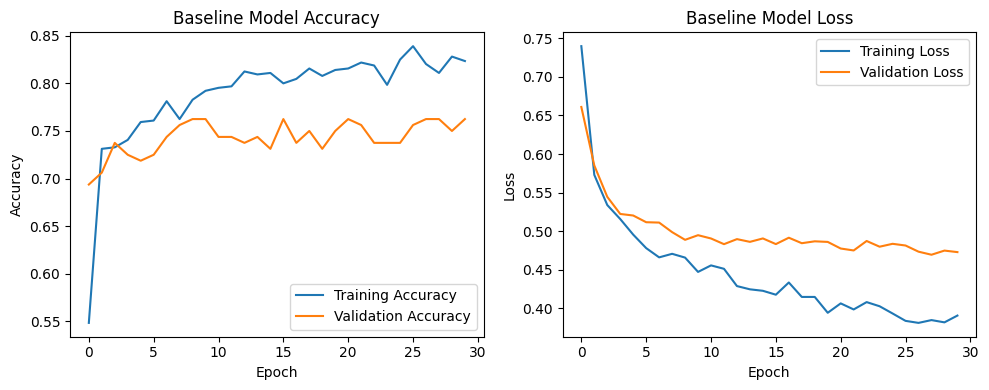

In [22]:
# Learning curve for baseline gender model
plt.figure(figsize=(10, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Baseline Model Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Baseline Model Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Learning curve for weighted gender model
plt.figure(figsize=(10, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_weighted.history["accuracy"], label="Training Accuracy")
plt.plot(history_weighted.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Weighted Model Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_weighted.history["loss"], label="Training Loss")
plt.plot(history_weighted.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Weighted Model Loss")
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy comparison
plt.subplot(1, 2, 1)
plt.plot(history.history["val_accuracy"], label="Baseline Val Accuracy")
plt.plot(history_weighted.history["val_accuracy"], label="Weighted Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Comparison")
plt.legend()

# Loss comparison
plt.subplot(1, 2, 2)
plt.plot(history.history["val_loss"], label="Baseline Val Loss")
plt.plot(history_weighted.history["val_loss"], label="Weighted Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Comparison")
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Save Age Classification Model

Saves the trained age classification model to disk in Keras format for future use.

In [23]:
# Save the model (age)
age_model.save("../models/mlp_age_merged_classification_model.keras")

# Define MFCC Feature Extraction Function

Extracts 13 MFCC features from an audio file by computing the mean across time frames.

In [24]:
def extract_mfcc_from_audio(path, n_mfcc=13):
    # Load audio at fixed sample rate
    audio, sr = librosa.load(path, sr=16000)

    # Remove leading/trailing silence
    audio, _ = librosa.effects.trim(audio)

    # Normalise amplitude
    audio = librosa.util.normalize(audio)

    # Extract MFCCs
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

    # Aggregate across time
    return mfcc.mean(axis=1)

# Load Trained Models and Scalers

Loads the saved gender and age classification models long with their respective feature scalers for making predictions.

In [25]:
# Load model and libraries for prediction
gender_model = load_model("../models/mlp_gender_classification_model.keras", compile=False)
age_model = load_model("../models/mlp_age_merged_classification_model.keras", compile=False)

# Load scaler for prediction
scaler = load("../models/feature_scaler.joblib")
age_scaler = load("../models/age_feature_scaler.joblib")

# Check Gender Label Distribution

Displays the proportion of each gender class in the dataset to assess class balance.

In [26]:
df["gender_label"].value_counts(normalize=True)

gender_label
0    0.731
1    0.269
Name: proportion, dtype: float64

# Test Gender Prediction on Sample Data

Selects one male and one female sample from the dataset, runs predictions, and displays true vs predicted gender with confidence probabilities.

In [27]:
# Qualitative inference on dataset samples (no audio playback)

# Select one male-labelled and one female-labelled sample
male_sample = df[df["gender_label"] == 0].sample(1, random_state=10).iloc[0]
female_sample = df[df["gender_label"] == 1].sample(1, random_state=10).iloc[0]

samples = {
    "Male-labelled sample": male_sample,
    "Female-labelled sample": female_sample
}

gender_labels = ["Male", "Female"]

for title, sample in samples.items():
    mfcc = sample[[col for col in df.columns if col.startswith("mfcc_")]].values

    pred = gender_model.predict(
        scaler.transform(mfcc.reshape(1, -1)),
        verbose=0
    )

    print(f"\n--- {title} ---")
    print("True gender:", sample["gender"])

    # Extract probabilities
    male_prob = pred[0][0]
    female_prob = pred[0][1]

    # Decision threshold (tuned to reduce majority-class bias)
    threshold = 0.45
    predicted_gender = "Female" if female_prob >= threshold else "Male"

    print("Predicted gender:", predicted_gender)
    print(f"Probability (Male): {male_prob:.2f}, (Female): {female_prob:.2f}")


--- Male-labelled sample ---
True gender: male_masculine
Predicted gender: Male
Probability (Male): 0.95, (Female): 0.05

--- Female-labelled sample ---
True gender: female_feminine
Predicted gender: Female
Probability (Male): 0.16, (Female): 0.84


# Generate Model Predictions

This section generates predicted gender labels for the test set using both the baseline and class-weighted models for subsequent evaluation and comparison. 

In [28]:
# Generate predictions from baseline model
y_pred_base = np.argmax(model.predict(X_test_scaled), axis=1)

# Generate predictions from weighted model
y_pred_weighted = np.argmax(weighted_model.predict(X_test_scaled), axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


# Confusion Matrix Calculation

This section computes matrices for both the baseline and weighted gender classification models to analyse class-specific prediction performance.

In [29]:
# Confusion matrix for both models calculation
cm_base = confusion_matrix(y_test, y_pred_base)
cm_weighted = confusion_matrix(y_test, y_pred_weighted)

# Confusion Matrix Visualisation

This section computes metrics and visualises confusion matrices for the baseline and weighted gender classification models using a shared colour scale to enable fair comparison of class-specific performance.

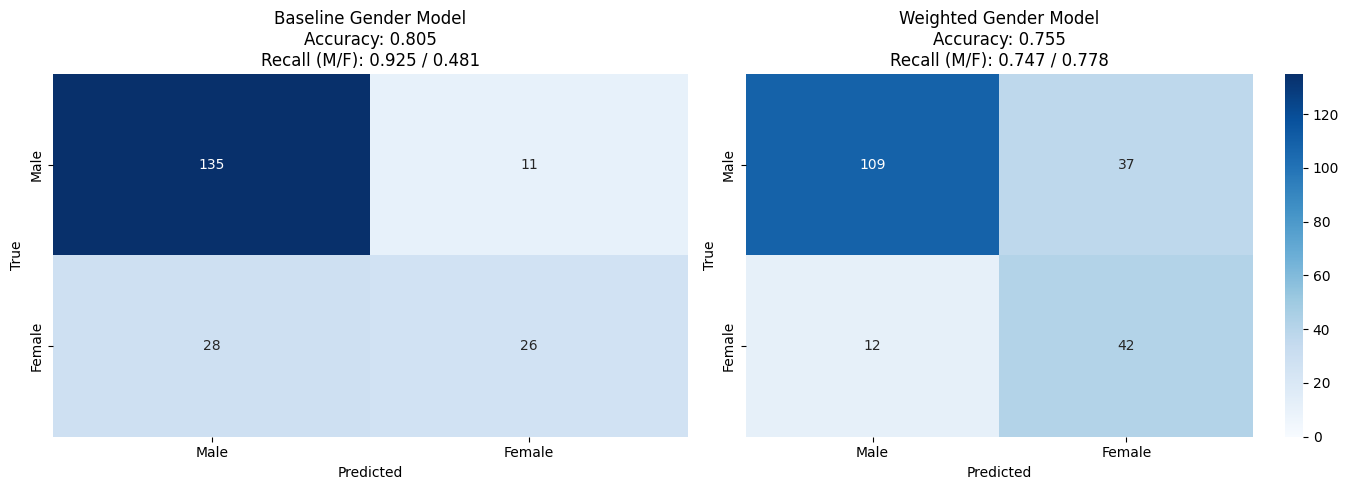

In [30]:
# Compute evaluation metrics
acc_base = accuracy_score(y_test, y_pred_base)
acc_weighted = accuracy_score(y_test, y_pred_weighted)

recall_base = recall_score(y_test, y_pred_base, average=None)
recall_weighted = recall_score(y_test, y_pred_weighted, average=None)

# Use a shared colour scale for fair comparison
vmax = max(cm_base.max(), cm_weighted.max())

# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Baseline model confusion matrix
sns.heatmap(
    cm_base,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Male", "Female"],
    yticklabels=["Male", "Female"],
    ax=axes[0],
    vmin=0,
    vmax=vmax,
    cbar=False
)

# Set titles and labels for baseline model
axes[0].set_title(
    f"Baseline Gender Model\n"
    f"Accuracy: {acc_base:.3f}\n"
    f"Recall (M/F): {recall_base[0]:.3f} / {recall_base[1]:.3f}"
)

axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# Weighted model confusion matrix
sns.heatmap(
    cm_weighted,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Male", "Female"],
    yticklabels=["Male", "Female"],
    ax=axes[1],
    vmin=0,
    vmax=vmax,
    cbar=True
)

# Set titles and labels for weighted model
axes[1].set_title(
    f"Weighted Gender Model\n"
    f"Accuracy: {acc_weighted:.3f}\n"
    f"Recall (M/F): {recall_weighted[0]:.3f} / {recall_weighted[1]:.3f}"
)

axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

# Adjust layout and show plot
plt.tight_layout()
plt.show()


# Qualitative Validation - Female Samples

This section evaluates the weighted gender classification model on a small set of randomly selected female samples to qualitatively assess recall and model behaviour.

In [31]:
# Test 10 random female samples
female_samples = df[df["gender_label"] == 1].sample(10, random_state=42)

labels = ["Male", "Female"]
correct_count = 0

print("Testing 10 Female Samples:")
print("=" * 70)

for idx, (_, sample) in enumerate(female_samples.iterrows(), 1):
    # Extract MFCC features from dataframe
    mfcc_features = sample[[col for col in df.columns if col.startswith("mfcc_")]].values

    # Predict gender
    gender_probs = weighted_model.predict(
        scaler.transform(mfcc_features.reshape(1, -1)),
        verbose=0
    )

    predicted_class = np.argmax(gender_probs)
    confidence = gender_probs[0][predicted_class]
    is_correct = (predicted_class == 1)

    if is_correct:
        correct_count += 1

    status = "✓" if is_correct else "✗"
    print(
        f"{status} Sample {idx}: "
        f"Predicted {labels[predicted_class]} "
        f"({confidence*100:.1f}% confidence)"
    )

print(f"\n{'=' * 70}")
print(f"Female Recall (sampled): {correct_count}/10 = {correct_count/10:.0%}")
print("Expected from confusion matrix: ~69%")

Testing 10 Female Samples:
✗ Sample 1: Predicted Male (56.1% confidence)
✓ Sample 2: Predicted Female (97.8% confidence)
✓ Sample 3: Predicted Female (76.0% confidence)
✓ Sample 4: Predicted Female (93.4% confidence)
✗ Sample 5: Predicted Male (53.7% confidence)
✓ Sample 6: Predicted Female (67.4% confidence)
✓ Sample 7: Predicted Female (81.9% confidence)
✓ Sample 8: Predicted Female (64.0% confidence)
✓ Sample 9: Predicted Female (65.1% confidence)
✓ Sample 10: Predicted Female (93.8% confidence)

Female Recall (sampled): 8/10 = 80%
Expected from confusion matrix: ~69%


# Qualitative Validation - Male Samples

This section evaluates the weighted gender classification model on a small set of randomly selected male samples to assess majority-class performance and ensure that class weighting does not degrade overall model behaviour. 

In [32]:
# Test 10 random male samples
male_samples = df[df["gender_label"] == 0].sample(10, random_state=42)

labels = ["Male", "Female"]
correct_count = 0

print("\nTesting 10 Male Samples:")
print("=" * 70)

for idx, (_, sample) in enumerate(male_samples.iterrows(), 1):
    # Extract MFCC from dataframe
    mfcc_features = sample[[col for col in df.columns if col.startswith('mfcc_')]].values
    
    # Predict
    gender_probs = weighted_model.predict(
        scaler.transform(mfcc_features.reshape(1, -1)),
        verbose=0
    )
    
    predicted_class = np.argmax(gender_probs)
    confidence = gender_probs[0][predicted_class]
    is_correct = (predicted_class == 0)
    
    if is_correct:
        correct_count += 1
    
    status = "✓" if is_correct else "✗"
    print(f"{status} Sample {idx}: Predicted {labels[predicted_class]} ({confidence*100:.1f}% conf)")

print(f"\n{'=' * 70}")
print(f"Male Recall (sampled): {correct_count}/10 = {correct_count/10:.0%}")



Testing 10 Male Samples:
✓ Sample 1: Predicted Male (90.3% conf)
✗ Sample 2: Predicted Female (55.7% conf)
✓ Sample 3: Predicted Male (80.0% conf)
✓ Sample 4: Predicted Male (95.2% conf)
✓ Sample 5: Predicted Male (92.6% conf)
✓ Sample 6: Predicted Male (56.2% conf)
✓ Sample 7: Predicted Male (66.7% conf)
✗ Sample 8: Predicted Female (60.9% conf)
✓ Sample 9: Predicted Male (83.9% conf)
✗ Sample 10: Predicted Female (63.0% conf)

Male Recall (sampled): 7/10 = 70%


# Qualitative Evaluation on Unseen Audio Samples

To assess model generalisation beyond the training distribution, two unseen English speech samples (one male and one female) were evaluated. These samples were not used during training or validation and represent realistic, real-world speech recordings.

In [39]:
test_samples = {
    "Unseen Female Sample": "../voice_demos/female_unseen_sample.wav",
    "Unseen Male Sample": "../voice_demos/male_unseen_sample.wav"
}

labels = ["Male", "Female"]

for name, path in test_samples.items():
    mfcc = extract_mfcc_from_audio(path)
    mfcc_scaled = scaler.transform(mfcc.reshape(1, -1))
    
    pred = gender_model.predict(mfcc_scaled, verbose=0)
    male_prob, female_prob = pred[0]
    
    threshold = 0.45
    predicted_gender = "Female" if female_prob >= threshold else "Male"
    
    confidence_gap = abs(male_prob - female_prob)
    if confidence_gap >= 0.30:
        confidence = "High"
    elif confidence_gap >= 0.15:
        confidence = "Moderate"
    else:
        confidence = "Low"
    
    print(f"\n{name}")
    print("-" * 40)
    print("Predicted gender:", predicted_gender)
    print(f"Male probability: {male_prob:.2f}")
    print(f"Female probability: {female_prob:.2f}")
    print("Confidence level:", confidence)


Unseen Female Sample
----------------------------------------
Predicted gender: Female
Male probability: 0.30
Female probability: 0.70
Confidence level: High

Unseen Male Sample
----------------------------------------
Predicted gender: Male
Male probability: 0.66
Female probability: 0.34
Confidence level: High
